# Conditional GAN Tutorial

Borrowed From: https://livebook.manning.com/book/gans-in-action/chapter-8/28

High Level Architecture Diagram

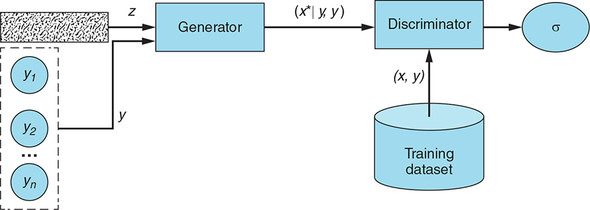

The CGAN Generator uses a random noise vector z and a label y (one of the n possible labels) as inputs and produces a fake example x*|y that strives to be both realistic looking and a convincing match for the label y.

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

from keras.datasets import mnist
from keras.layers import (
        Activation, BatchNormalization, Concatenate, Dense,
        Embedding, Flatten, Input, Multiply, Reshape)
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.models import Model, Sequential
from keras.optimizers import Adam

We also specify the input image size, the size of the noise vector z, and the number of classes in our dataset, as shown here.

In [ ]:
img_rows = 28
img_cols = 28
channels = 1

img_shape = (img_rows, img_cols, channels)

z_dim = 100

num_classes = 10

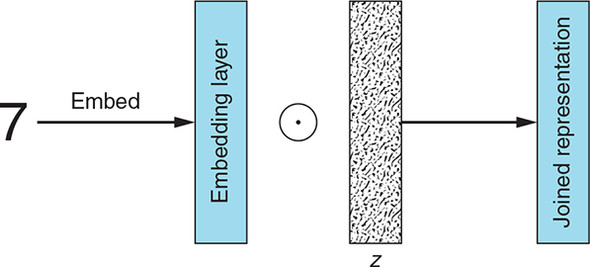

In [ ]:
def build_generator(z_dim):

    model = Sequential()

    model.add(Dense(256 * 7 * 7, input_dim=z_dim))                           
    model.add(Reshape((7, 7, 256)))

    model.add(Conv2DTranspose(128, kernel_size=4, strides=2, padding='same')) # To avoid sparsity 

    model.add(BatchNormalization())                                          

    model.add(LeakyReLU(alpha=0.01))                                         

    model.add(Conv2DTranspose(64, kernel_size=4, strides=1, padding='same')) 

    model.add(BatchNormalization())                                          

    model.add(LeakyReLU(alpha=0.01))   # Relaxes sparsity                           

    model.add(Conv2DTranspose(1, kernel_size=4, strides=2, padding='same'))  

    model.add(Activation('tanh')) # use tanh instead of sigmoid a trick for GANs                                           

    return model


def build_cgan_generator(z_dim):

    z = Input(shape=(z_dim, ))                                               

    label = Input(shape=(1, ), dtype='int32')                                

    label_embedding = Embedding(num_classes, z_dim, input_length=1)(label)   

    label_embedding = Flatten()(label_embedding)                             

    joined_representation = Multiply()([z, label_embedding])                

    generator = build_generator(z_dim)

    conditioned_img = generator(joined_representation)                     

    return Model([z, label], conditioned_img)

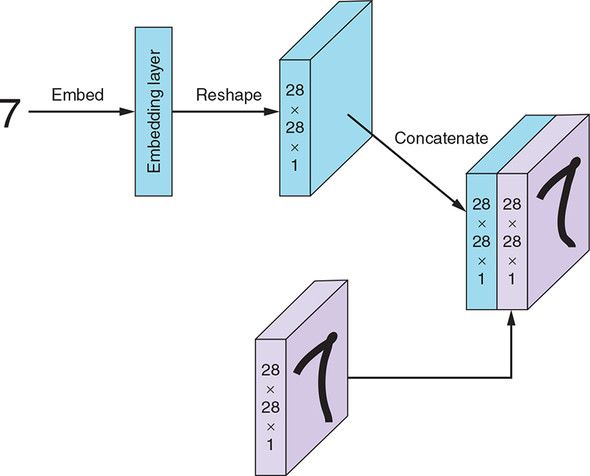

In [ ]:
def build_discriminator(img_shape):

    model = Sequential()

    # Increase depth of model from 32 to 64 as there is 
    # more info to encode because of the concatenated label embedding

    # Convolutional layer, from 28 × 28 × 2 into 14 × 14 × 64 tensor
    model.add(                                                        

        Conv2D(64,
               kernel_size=4,
               strides=2,
               input_shape=(img_shape[0], img_shape[1], img_shape[2] + 1),
               padding='same'))

    model.add(LeakyReLU(alpha=0.01))                                  

    # Convolutional layer, from 14 × 14 × 64 into 7 × 7 × 64 tensor
    model.add(                                                        
        Conv2D(64,
               kernel_size=4,
               strides=2,
               input_shape=img_shape,
               padding='same'))

    model.add(BatchNormalization())                                   

    model.add(LeakyReLU(alpha=0.01))                                  

    model.add(                                                        
        Conv2D(128,
               kernel_size=4,
               strides=2,
               input_shape=img_shape,
               padding='same'))

    model.add(BatchNormalization())                                   

    model.add(LeakyReLU(alpha=0.01))                                  

    model.add(Flatten())                                              
    model.add(Dense(1, activation='sigmoid'))

    return model


def build_cgan_discriminator(img_shape):

    img = Input(shape=img_shape)                                      

    label = Input(shape=(1, ), dtype='int32')                         

    label_embedding = Embedding(num_classes,                          
                                np.prod(img_shape),
                                input_length=1)(label)

    label_embedding = Flatten()(label_embedding)                      

    label_embedding = Reshape(img_shape)(label_embedding)             

    concatenated = Concatenate(axis=-1)([img, label_embedding])       

    discriminator = build_discriminator(img_shape)

    classification = discriminator(concatenated)                      

    return Model([img, label], classification)

Build the Model

In [ ]:
def build_cgan(generator, discriminator):

    z = Input(shape=(z_dim, ))                               

    label = Input(shape=(1, ))                               

    img = generator([z, label])                              

    classification = discriminator([img, label])

    model = Model([z, label], classification)                

    return model


discriminator = build_cgan_discriminator(img_shape)          
discriminator.compile(loss='binary_crossentropy',
                      optimizer=Adam(),
                      metrics=['accuracy'])

generator = build_cgan_generator(z_dim)                      

discriminator.trainable = False                              

cgan = build_cgan(generator, discriminator)                  
cgan.compile(loss='binary_crossentropy', optimizer=Adam())

In [ ]:
accuracies = []
losses = []


def train(iterations, batch_size, sample_interval):

    (X_train, y_train), (_, _) = mnist.load_data()                           

    X_train = X_train / 127.5 - 1.                                           
    X_train = np.expand_dims(X_train, axis=3)

    real = np.ones((batch_size, 1))                                          

    fake = np.zeros((batch_size, 1))                                         

    for iteration in range(iterations):



        idx = np.random.randint(0, X_train.shape[0], batch_size)             
        imgs, labels = X_train[idx], y_train[idx]

        z = np.random.normal(0, 1, (batch_size, z_dim))                      
        gen_imgs = generator.predict([z, labels])

        d_loss_real = discriminator.train_on_batch([imgs, labels], real)     
        d_loss_fake = discriminator.train_on_batch([gen_imgs, labels], fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        z = np.random.normal(0, 1, (batch_size, z_dim))                      

        labels = np.random.randint(0, num_classes, batch_size).reshape(-1, 1)

        g_loss = cgan.train_on_batch([z, labels], real)                      

        if (iteration + 1) % sample_interval == 0:

            print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" %             
                  (iteration + 1, d_loss[0], 100 * d_loss[1], g_loss))

            losses.append((d_loss[0], g_loss))                               
            accuracies.append(100 * d_loss[1])

            sample_images()                                                  

In [ ]:
def sample_images(image_grid_rows=2, image_grid_columns=5):

    z = np.random.normal(0, 1, (image_grid_rows * image_grid_columns, z_dim))

    labels = np.arange(0, 10).reshape(-1, 1)                                 

    gen_imgs = generator.predict([z, labels])                                

    gen_imgs = 0.5 * gen_imgs + 0.5                                          

    fig, axs = plt.subplots(image_grid_rows,                                 
                            image_grid_columns,
                            figsize=(10, 4),
                            sharey=True,
                            sharex=True)

    cnt = 0
    for i in range(image_grid_rows):
        for j in range(image_grid_columns):
            axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')            
            axs[i, j].axis('off')
            axs[i, j].set_title("Digit: %d" % labels[cnt])
            cnt += 1

1000 [D loss: 0.000754, acc.: 100.00%] [G loss: 0.157165]
2000 [D loss: 0.000011, acc.: 100.00%] [G loss: 0.005577]
3000 [D loss: 0.000006, acc.: 100.00%] [G loss: 0.002547]
4000 [D loss: 0.000001, acc.: 100.00%] [G loss: 0.002765]
5000 [D loss: 0.000001, acc.: 100.00%] [G loss: 0.001861]
6000 [D loss: 0.000000, acc.: 100.00%] [G loss: 0.000363]
7000 [D loss: 0.000000, acc.: 100.00%] [G loss: 0.000066]
8000 [D loss: 0.000000, acc.: 100.00%] [G loss: 0.000065]
9000 [D loss: 0.000000, acc.: 100.00%] [G loss: 0.000027]
10000 [D loss: 0.000000, acc.: 100.00%] [G loss: 0.000024]
11000 [D loss: 0.000000, acc.: 100.00%] [G loss: 0.000012]
12000 [D loss: 0.000000, acc.: 100.00%] [G loss: 0.000010]


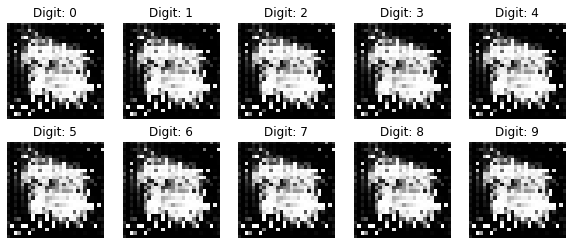

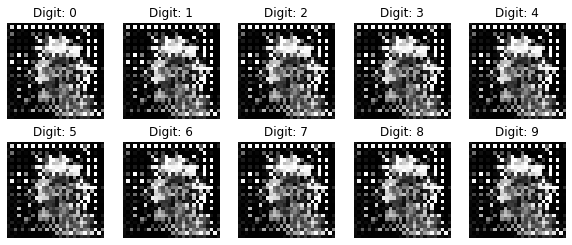

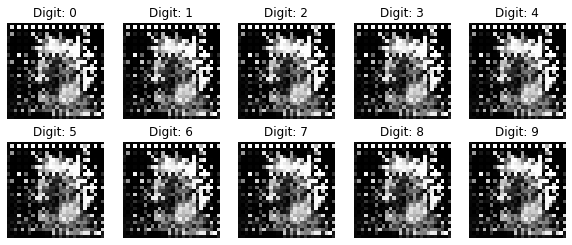

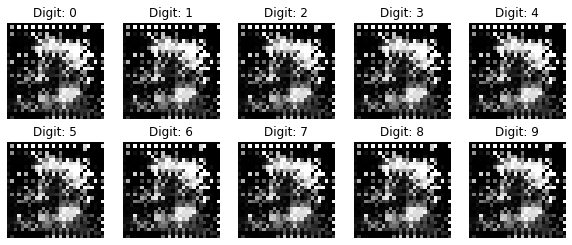

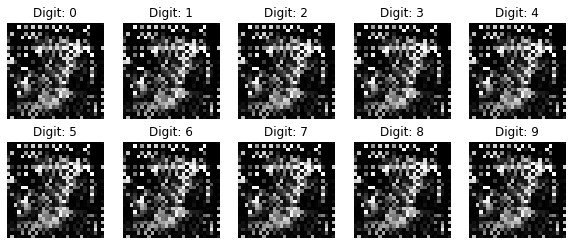

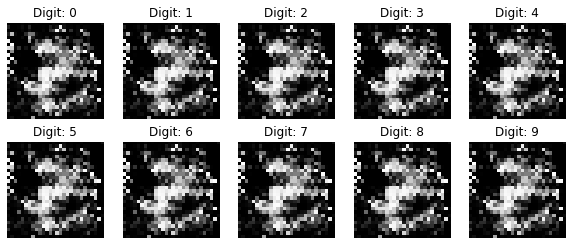

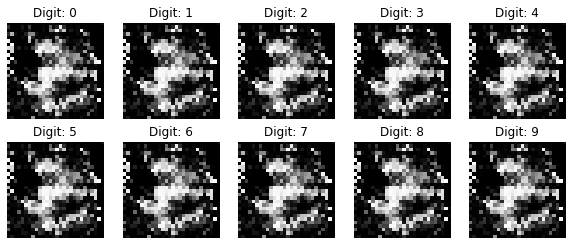

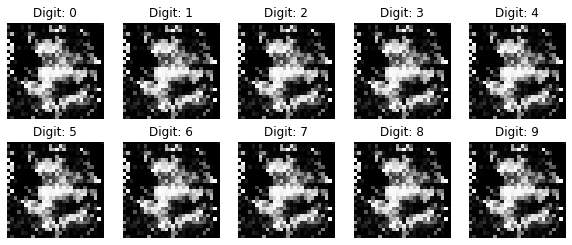

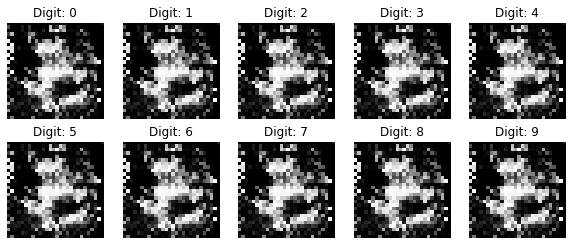

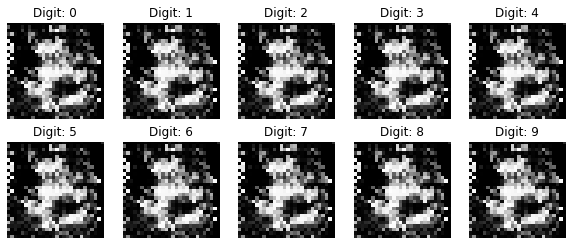

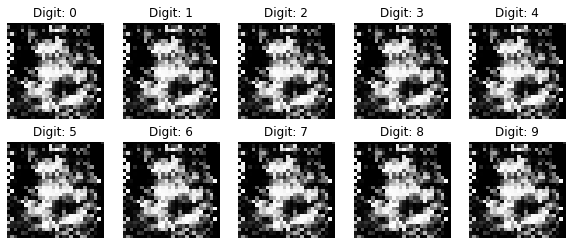

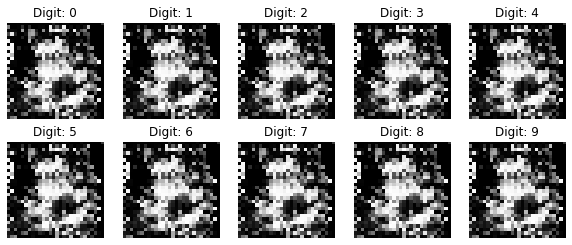

In [ ]:
iterations = 12000                                
batch_size = 32
sample_interval = 1000

train(iterations, batch_size, sample_interval)    
